In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

summ = pd.read_csv('Feb23_summtab.csv')
alls = pd.read_csv('current_summ.csv') 

cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
cross2['Part'] = 2

mlist2 = ['OII I','OIII I','OIV I']
mlist1 = ['OII I','OIII I']

#saving figure function
def sf(name,dpi=150):
    plt.savefig(f'Figs/{name}.png',bbox_inches='tight',dpi=dpi)
#simple plotting function
def plot(s,calib=False,both=True):
    try:band = o.getIV(s,cross,both=both,stack=True,plot=True,mlist=mlist1,figsize=(4,3),calib=calib)
    except:band = o.getIV(s,cross2,both=both,stack=True,plot=True,mlist=mlist2,figsize=(4,3),calib=calib)
        
#set plot styles
import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 9
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1.2

mpl.rcParams['ytick.major.size'] = 9
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1.2

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams['ytick.right'] = True

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.minor.visible'] = True

mpl.rcParams['xtick.top'] = True

#dictionaries to get new source numbers and names from old source numbers
src_dict = dict(zip(np.array(alls['src_n']), np.array(alls['new src_n'])))
name_dict = dict(zip(np.array(summ['src_n']), np.array(summ['name'])))

from matplotlib.patches import Rectangle as rec
from matplotlib.lines import Line2D

# Simple Analysis of Phase-Folded Light Curves
- mostly the same code as Mar23_OpticalXrayPeriod but less plotting; adjusted to use for all sources; and saving skew and kurtosis information
- recreating kurtosis vs. skew figure with a few examples highlighted

In [13]:
# (just first time running) add columns to summ
summ['est. skew'] = np.nan
summ['est. kurtosis'] = np.nan
summ['est. range'] = np.nan

summ['near est. skew'] = np.nan
summ['near est. kurtosis'] = np.nan
summ['near est. range'] = np.nan

summ['Coe skew'] = np.nan
summ['Coe kurtosis'] = np.nan
summ['Coe range'] = np.nan

summ['near Coe skew'] = np.nan
summ['near Coe kurtosis'] = np.nan
summ['near Coe range'] = np.nan

summ['2-200d skew'] = np.nan
summ['2-200d kurtosis'] = np.nan
summ['2-200d range'] = np.nan

summ['X-ray skew'] = np.nan
summ['X-ray kurtosis'] = np.nan
summ['X-ray range'] = np.nan

In [2]:
def phase_on_ax(iband,cax,period,label,pbins=16,det=True):
    if det: yax = 'I detrend'
    else: yax = 'I mag'
    cax.errorbar((iband['MJD-50000']%period)/period,iband[yax],yerr=iband['I mag err'],color=pink,alpha=0.3,ls='none',marker='o',markersize=5,zorder=2)
    cax.errorbar(1+(iband['MJD-50000']%period)/period,iband[yax],yerr=iband['I mag err'],color=pink,alpha=0.3,ls='none',marker='o',markersize=5,zorder=2)
    mid,avg,std = o.meanphase(iband,period,pbins=pbins,det=det,double=True,stdev=True,sterr=True,divide=True)
    cax.step(mid,avg,where='mid',color='black',label=f'{label} {period:.2f}, range {np.nanmax(avg)-np.nanmin(avg):.3f}',zorder=3)
    #add errors as one sigma
    cax.errorbar(mid,avg,yerr=std,color='black',marker='',linestyle='none',alpha=0.5,zorder=4)
    maxa,mina = np.nanmax(avg)+std[np.nanargmax(avg)],np.nanmin(avg)-std[np.nanargmin(avg)]
    cax.set_ylim(maxa+.01,mina-.01)
    cax.legend(fontsize=11)

In [4]:
def describe_phase(iband,period,pbins=16,det=True):
    mid,avg,std = o.meanphase(iband,period,pbins=pbins,det=det,double=True,stdev=True,sterr=True,divide=True)
    prange = np.nanmax(avg)-np.nanmin(avg)
    skew = st.skew(avg,nan_policy='omit')
    kurtosis = st.kurtosis(avg,nan_policy='omit')
    return prange,skew,kurtosis

In [77]:
srcs = np.array(summ['src_n'])
column_dict = {'best 2-200d period': '2-200d',
              'est. period':'est.',
              'Coe est. period':'Coe',
              'X-ray period':'X-ray',
              'best auto det pd':'near est.',
              'best near Coe': 'near Coe'}

In [78]:
def add_phase_to_summ(src,pbins=16,det=True,plot_sk=False):
    #get I band data and detrend with spline
    try:iband,vband = o.getIV(src,cross,stack=True,plot=False)
    except:iband,vband = o.getIV(src,cross2,mlist=mlist2,stack=True,plot=False) 
    if det: iband = o.splinedetrend(iband,rettemp=True) #uses defaults
    
    new_row = summ[summ['src_n']==src]
    row = new_row.iloc[0]

    if plot_sk: 
        colors = ['#ddd8c4', '#a3c9a8', '#84b59f', '#69a297', '#50808e','#9CADCE']
        markers = ['o','x','v','*','p','h']
    for i in range(len(column_dict.keys())):
        key = list(column_dict.keys())[i]
        period = row[key]
        if not np.isnan(period) and period>0:
            prange,skew,kurtosis = describe_phase(iband,period,pbins=pbins,det=det)
            new_col = column_dict[key]
            new_row[f'{new_col} skew'] = skew
            new_row[f'{new_col} kurtosis'] = kurtosis
            new_row[f'{new_col} range'] = prange
            if plot_sk: #plot kurtosis vs. skew for the one source
                plt.scatter(skew,kurtosis,color=colors[i],label=new_col,marker=markers[i])
                #plt.text(skew,kurtosis,f'{new_col}',fontsize=12)
                plt.ylabel('Phase-Folded Kurtosis',fontsize=14)
                plt.xlabel('Phase-Folded Skew',fontsize=14)
                nsrcn = src_dict[src]
                plt.title(f'Source #{nsrcn}',fontsize=14)
                plt.legend()
    
    summ[summ['src_n']==src] = new_row

In [46]:
for i in srcs:
    try:add_phase_to_summ(i)
    except:print(f'Source #{i} not working...')

empty file for OIII I
Source #1 not working...
empty file for OIII I
empty file for OII I
empty file for OIII I


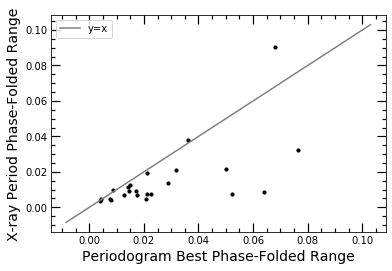

In [85]:
def xy(legend=False):
    ax = plt.gca()
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()])]
    if legend:
        plt.plot(lims,lims,color='grey',label='y=x')
        plt.legend()
    else:
        plt.plot(lims,lims,color='grey')    
        
#periodogram seems to generally find higher phase-folded range... but not always
#true for other established periods as well
plt.scatter(summ['2-200d range'],summ['X-ray range'],s=10,color='black')
plt.ylabel('X-ray Period Phase-Folded Range',fontsize=14)
plt.xlabel('Periodogram Best Phase-Folded Range',fontsize=14)
xy(legend=True)

In [84]:
for i in column_dict.values():    
    plt.scatter(summ[f'{i} skew'],summ[f'{i} kurtosis'],s=10,c='black')#c=np.log10(summ['2-200d range']),cmap='magma')
    plt.xlabel('Phase-Folded Skew',fontsize=14)
    plt.ylabel('Phase-Folded Kurtosis',fontsize=14)
    plt.savefig(f'SkewKurtosisMar23/skew_kurtosis_{i}.pdf',bbox_inches='tight')
    plt.close()

# ~All Sources on Kurtosis vs. Skew Plot 
- throughout, be sure to use manual periods found for type 4 sources
- a few examples from different regions of plot

- mark sources with periods under FAL 0.001 and do version without those
- version with best period (qualitatively or with range for now)
- version with all the decent periods for the source
- can color based on whether X-ray period; can color with range; can color with period

### version using periodogram result across the board
- if using this version, choose better array of examples


In [132]:
example_sources = [6,7,11,36]

labdict = {example_sources[-1]:'a',example_sources[0]:'b',example_sources[-2]:'c',example_sources[1]:'d'}
def circle(src,ax,column='2-200d'):
    row = summ[summ['src_n']==src].iloc[0]
    ax.scatter(row[f'{column} skew'],row[f'{column} kurtosis'],facecolor='none',color=pink,s=100,alpha=0.8)
    label = labdict[src]
    ax.text(row[f'{column} skew'],row[f'{column} kurtosis']+.3,label,zorder=5,color='#32585D')
    #ax.text(row[f'{column} skew'],row[f'{column} kurtosis']+.3,label,zorder=5)

In [133]:
#60 and 63 (old source numbers): use 'best period'
iband,vband = o.getIV(60,cross,stack=True,plot=False)
iband = o.splinedetrend(iband,rettemp=True) 
period = alls[alls['src_n']==60].iloc[0]['best period']
prange60,skew60,kurtosis60 = describe_phase(iband,period,pbins=16,det=True)

iband,vband = o.getIV(63,cross,stack=True,plot=False)
iband = o.splinedetrend(iband,rettemp=True) 
period = alls[alls['src_n']==63].iloc[0]['best period']
prange63,skew63,kurtosis63 = describe_phase(iband,period,pbins=16,det=True)

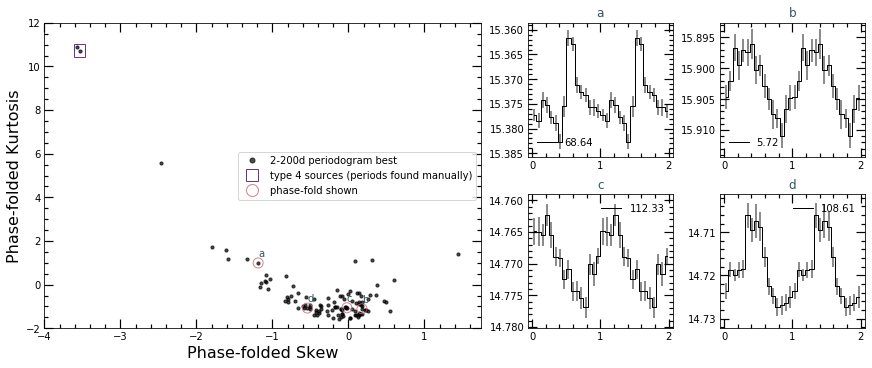

In [135]:
#use subplots
fig3 = plt.figure(figsize=(12,5),constrained_layout=True)
gs = fig3.add_gridspec(4,10)
ax1 = fig3.add_subplot(gs[:, :-4])
ax2 = fig3.add_subplot(gs[:2, -4:-2])
ax2.set_title('a',color='#32585D') #: src 36
ax3 = fig3.add_subplot(gs[:2, -2:])
ax3.set_title('b',color='#32585D') #: src 6
ax4 = fig3.add_subplot(gs[2:, -4:-2])
ax4.set_title('c',color='#32585D') #: src 11
ax5 = fig3.add_subplot(gs[2:, -2:])
ax5.set_title('d',color='#32585D') #: src 7

ax1.scatter(summ['2-200d skew'],summ['2-200d kurtosis'],color='black',s=10,alpha=0.7)
#start by using (old) source numbers 6, 7, 11, and 36 for examples

axes = [ax3,ax5,ax4,ax2]
for i in range(len(example_sources)):
    current_source = example_sources[i]
    iband = o.getIV(current_source,cross,stack=True,both=False)
    iband = o.splinedetrend(iband,rettemp=True)
    period = summ[summ['src_n']==current_source].iloc[0]['best 2-200d period']
    mid,avg,err = o.meanphase(iband,period,pbins=16,det=True,double=True,stdev=True,sterr=True,divide=True)
    current_ax = axes[i]
    current_ax.step(mid,avg,where='mid',color='black',linewidth=1,label=f'{period:.2f}')
    current_ax.errorbar(mid,avg,yerr=err,color='black',alpha=0.6,ls='none')
    amax = np.nanmax(avg)+np.nanmax(err)
    amin = np.nanmin(avg)-np.nanmax(err)
    current_ax.set_ylim(amax+.001,amin-.001)
    current_ax.set_xlim(0,2)
    circle(current_source,ax1)

ax1.set_ylabel('Phase-folded Kurtosis',fontsize=16)
ax1.set_xlabel('Phase-folded Skew',fontsize=16)

ax1.set_ylim(-2,12)
ax1.set_xlim(-4,1.75)
ax1.scatter(skew60,kurtosis60,color='black',s=10,alpha=0.7)
ax1.scatter(skew63,kurtosis63,color='black',s=10,alpha=0.7)

ax1.add_patch(rec((-3.617,10.45),.15,.6,facecolor='none',edgecolor='rebeccapurple'))


ax2.legend(frameon=False);ax3.legend(frameon=False);ax4.legend(frameon=False);ax5.legend(frameon=False)

legend_elements = [#Line2D([0], [0], color='navy',marker='x',markersize=8, label='pdgram best',ls='none'),
                   #Line2D([0], [0], color='darkseagreen',marker='x',markersize=8, label='established from X-ray',ls='none'),
                  #Line2D([0], [0], color='black',marker='o', label='best, no established from X-ray',ls='none',alpha=0.5,markersize=5),
                Line2D([0], [0], color='black',marker='o', label='2-200d periodogram best',ls='none',alpha=0.7,markersize=5),
                  #Line2D([0], [0], color='grey', label='same source',alpha=0.7),
                Line2D([0], [0],marker='s',markersize=12,label='type 4 sources (periods found manually)',markerfacecolor='none',markeredgecolor='rebeccapurple',ls='none'),
                  Line2D([0], [0], marker='o',markerfacecolor='none',color=pink,markersize=12,alpha=0.8, label='phase-fold shown',ls='none')]
ax1.legend(handles=legend_elements,loc='center right')

# plt.savefig(f'SkewKurtosisMar23/skew_kurtosis_examples_periodogram.pdf',bbox_inches='tight') #just change last descriptor in iterations



### version with "best period" using highest range

### version with all periods for a source, connected with e.g., grey line

### version emphasizing (which have) X-ray periods

In [55]:
summ.to_csv('Feb23_summtab.csv',index=False)

# Future Options
- adapt 2021 code to do more analysis of phase-folded shapes
- compare kurtosis vs. skew to Bird et al. 2012 approach